# 二维卷积层

<font color='red'>卷积神经网络（convolutional neural network）是含有卷积层（convolutional layer）的神经网络</font>。本章中介绍的卷积神经网络均使用最常见的二维卷积层。它有高和宽两个空间维度，常用来处理图像数据。本节中，我们将介绍简单形式的二维卷积层的工作原理。


## 二维互相关运算

虽然卷积层得名于卷积（convolution）运算，但我们通常在卷积层中使用更加直观的互相关（cross-correlation）运算。在二维卷积层中，一个二维输入数组和一个二维核（kernel）数组通过互相关运算输出一个二维数组。
我们用一个具体例子来解释二维互相关运算的含义。如图5.1所示，输入是一个高和宽均为3的二维数组。我们将该数组的形状记为$3 \times 3$或（3，3）。核数组的高和宽分别为2。该数组在卷积计算中又称<font color='red'>卷积核或过滤器（filter）</font>。卷积核窗口（又称卷积窗口）的形状取决于卷积核的高和宽，即$2 \times 2$。图5.1中的阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：$0\times0+1\times1+3\times2+4\times3=19$。


在二维互相关运算中，卷积窗口从输入数组的<font color='red'>最左上方开始，按从左往右、从上往下</font>的顺序，依次在输入数组上滑动。当卷积窗口滑动到某一位置时，窗口中的输入子数组与核数组按元素相乘并求和，得到输出数组中相应位置的元素。图5.1中的输出数组高和宽分别为2，其中的4个元素由二维互相关运算得出：

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.\\
$$

下面我们将上述过程实现在`corr2d`函数里。它接受输入数组`X`与核数组`K`，并输出数组`Y`。

In [2]:
from mxnet import autograd, nd
from mxnet.gluon import nn

def corr2d(X, K):  # 本函数已保存在d2lzh包中方便以后使用
    h, w = K.shape
    Y = nd.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

我们可以构造图5.1中的输入数组`X`、核数组`K`来验证二维互相关运算的输出。

In [5]:
X = nd.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = nd.array([[0, 1], [2, 3]])
corr2d(X, K)


[[19. 25.]
 [37. 43.]]
<NDArray 2x2 @cpu(0)>

## 二维卷积层

二维卷积层将输入和卷积核做互相关运算，并加上一个<font color='red'>标量偏差</font>来得到输出。卷积层的模型参数包括了<font color='red'>卷积核和标量偏差</font>。在训练模型的时候，通常我们先对卷积核<font color='red'>随机初始化</font>，然后不断迭代卷积核和偏差。

下面基于`corr2d`函数来实现一个自定义的二维卷积层。在构造函数`__init__`里我们声明`weight`和`bias`这两个模型参数。前向计算函数`forward`则是直接调用`corr2d`函数再加上偏差。

In [26]:
class Conv2D(nn.Block):
    def __init__(self, kernel_size, **kwargs):
        super(Conv2D, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=kernel_size)
        self.bias = self.params.get('bias', shape=(1,))

    def forward(self, x):
        return corr2d(x, self.weight.data()) + self.bias.data()

卷积窗口形状为$p \times q$的卷积层称为$p \times q$卷积层。同样，$p \times q$卷积或$p \times q$卷积核说明卷积核的高和宽分别为$p$和$q$。


## 图像中物体边缘检测

下面我们来看一个卷积层的简单应用：检测图像中物体的边缘，即找到像素变化的位置。首先我们构造一张$6\times 8$的图像（即高和宽分别为6像素和8像素的图像）。它中间4列为黑（0），其余为白（1）。

In [19]:
X = nd.ones((6, 8))
X[:, 2:6] = 0
X


[[1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]]
<NDArray 6x8 @cpu(0)>

然后我们构造一个高和宽分别为1和2的卷积核`K`。当它与输入做互相关运算时，如果横向相邻元素相同，输出为0；否则输出为非0。

In [20]:
K = nd.array([[1, -1]])

下面将输入`X`和我们设计的卷积核`K`做互相关运算。可以看出，我们将从白到黑的边缘和从黑到白的边缘分别检测成了1和-1。其余部分的输出全是0。

In [25]:
Y = corr2d(X, K)
Y


[[ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]]
<NDArray 6x7 @cpu(0)>

由此，我们可以看出，卷积层可通过重复使用卷积核有效地<font color='red'>表征局部空间</font>。


## 通过数据学习核数组

最后我们来看一个例子，它使用物体边缘检测中的输入数据`X`和输出数据`Y`来学习我们构造的核数组`K`。我们首先构造一个卷积层，将其卷积核初始化成随机数组。接下来在每一次迭代中，我们使用平方误差来比较`Y`和卷积层的输出，然后计算梯度来更新权重。简单起见，这里的卷积层忽略了偏差。

虽然我们之前构造了`Conv2D`类，但由于`corr2d`使用了对单个元素赋值（`[i, j]=`）的操作因而无法自动求梯度。下面我们使用Gluon提供的`Conv2D`类来实现这个例子。

In [27]:
# 构造一个输出通道数为1（将在“多输入通道和多输出通道”一节介绍通道），核数组形状是(1, 2)的二
# 维卷积层
conv2d = nn.Conv2D(1, kernel_size=(1, 2))
conv2d.initialize()

# 二维卷积层使用4维输入输出，格式为(样本, 通道, 高, 宽)，这里批量大小（批量中的样本数）和通
# 道数均为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))

for i in range(10):
    with autograd.record():
        Y_hat = conv2d(X)
        l = (Y_hat - Y) ** 2
    l.backward()
    # 简单起见，这里忽略了偏差
    conv2d.weight.data()[:] -= 3e-2 * conv2d.weight.grad()
    if (i + 1) % 2 == 0:
        print('batch %d, loss %.3f' % (i + 1, l.sum().asscalar()))

batch 2, loss 4.949
batch 4, loss 0.831
batch 6, loss 0.140
batch 8, loss 0.024
batch 10, loss 0.004


可以看到，10次迭代后误差已经降到了一个比较小的值。现在来看一下学习到的核数组。

In [8]:
conv2d.weight.data().reshape((1, 2))


[[ 0.9895    -0.9873705]]
<NDArray 1x2 @cpu(0)>

可以看到，学到的核数组与我们之前定义的核数组`K`较接近。

## 互相关运算和卷积运算

实际上，<font color='red'>卷积运算与互相关运算类似</font>。为了得到卷积运算的输出，我们只需将核数组左右翻转并上下翻转，再与输入数组做互相关运算。可见，卷积运算和互相关运算虽然类似，但如果它们使用相同的核数组，对于同一个输入，输出往往并不相同。

那么，你也许会好奇卷积层为何能使用互相关运算替代卷积运算。其实，在深度学习中核数组都是学出来的：卷积层无论使用互相关运算或卷积运算都不影响模型预测时的输出。为了解释这一点，假设卷积层使用互相关运算学出图5.1中的核数组。设其他条件不变，使用卷积运算学出的核数组即图5.1中的核数组按上下、左右翻转。也就是说，图5.1中的输入与学出的已翻转的核数组再做卷积运算时，依然得到图5.1中的输出。为了与大多数深度学习文献一致，如无特别说明，本书中提到的卷积运算均指互相关运算。


## 特征图和感受野

二维卷积层输出的二维数组可以看作是输入在空间维度（宽和高）上某一级的表征，也叫<font color='red'>特征图（feature map）</font>。影响元素$x$的前向计算的所有可能输入区域（可能大于输入的实际尺寸）叫做$x$的<font color='red'>感受野（receptive field）</font>。以图5.1为例，输入中阴影部分的四个元素是输出中阴影部分元素的感受野。我们将图5.1中形状为$2 \times 2$的输出记为$Y$，并考虑一个更深的卷积神经网络：将$Y$与另一个形状为$2 \times 2$的核数组做互相关运算，输出单个元素$z$。那么，$z$在$Y$上的感受野包括$Y$的全部四个元素，在输入上的感受野包括其中全部9个元素。可见，我们可以通过更深的卷积神经网络使特征图中单个元素的感受野变得更加广阔，从而捕捉输入上更大尺寸的特征。

我们常使用“元素”一词来描述数组或矩阵中的成员。在神经网络的术语中，这些元素也可称为“单元”。当含义明确时，本书不对这两个术语做严格区分。


## 小结

* 二维卷积层的核心计算是二维互相关运算。在最简单的形式下，它对二维输入数据和卷积核做互相关运算然后加上偏差。
* 我们可以设计卷积核来检测图像中的边缘。
* 我们可以通过数据来学习卷积核。

# 填充和步幅

在上一节的例子里，我们使用高和宽为3的输入与高和宽为2的卷积核得到高和宽为2的输出。一般来说，假设输入形状是$n_h\times n_w$，卷积核窗口形状是$k_h\times k_w$，那么输出形状将会是

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

所以卷积层的输出形状由输入形状和卷积核窗口形状决定。本节我们将介绍卷积层的两个超参数，即填充和步幅。它们可以对给定形状的输入和卷积核改变输出形状。

## 填充

填充（padding）是指在<font color='red'>输入高和宽的两侧填充元素（通常是0元素）</font>。图5.2里我们在原输入高和宽的两侧分别添加了值为0的元素，使得输入高和宽从3变成了5，并导致输出高和宽由2增加到4。图5.2中的阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：$0\times0+0\times1+0\times2+0\times3=0$。



一般来说，如果在高的两侧一共填充$p_h$行，在宽的两侧一共填充$p_w$列，那么输出形状将会是

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1),$$

也就是说，输出的高和宽会分别增加$p_h$和$p_w$。

在很多情况下，我们会设置$p_h=k_h-1$和$p_w=k_w-1$来使输入和输出具有相同的高和宽。这样会方便在构造网络时推测每个层的输出形状。假设这里$k_h$是奇数，我们会在高的两侧分别填充$p_h/2$行。如果$k_h$是偶数，一种可能是在输入的顶端一侧填充$\lceil p_h/2\rceil$行，而在底端一侧填充$\lfloor p_h/2\rfloor$行。在宽的两侧填充同理。

卷积神经网络经常使用奇数高宽的卷积核，如1、3、5和7，所以两端上的填充个数相等。对任意的二维数组`X`，设它的第`i`行第`j`列的元素为`X[i,j]`。当两端上的填充个数相等，并使输入和输出具有相同的高和宽时，我们就知道输出`Y[i,j]`是由输入以`X[i,j]`为中心的窗口同卷积核进行互相关计算得到的。

下面的例子里我们创建一个高和宽为3的二维卷积层，然后设输入高和宽两侧的填充数分别为1。给定一个高和宽为8的输入，我们发现输出的高和宽也是8。

In [1]:
from mxnet import nd
from mxnet.gluon import nn

# 定义一个函数来计算卷积层。它初始化卷积层权重，并对输入和输出做相应的升维和降维
def comp_conv2d(conv2d, X):
    conv2d.initialize()
    # (1, 1)代表批量大小和通道数（“多输入通道和多输出通道”一节将介绍）均为1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])  # 排除不关心的前两维：批量和通道

# 注意这里是两侧分别填充1行或列，所以在两侧一共填充2行或列
conv2d = nn.Conv2D(1, kernel_size=3, padding=(1,1))
X = nd.random.uniform(shape=(8, 8))
comp_conv2d(conv2d, X).shape

(8, 8)

当卷积核的高和宽不同时，我们也可以通过设置高和宽上不同的填充数使输出和输入具有相同的高和宽。

In [2]:
# 使用高为5、宽为3的卷积核。在高和宽两侧的填充数分别为2和1
conv2d = nn.Conv2D(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

(8, 8)

## 步幅

在上一节里我们介绍了二维互相关运算。卷积窗口从输入数组的<font color='red'>最左上方开始，按从左往右、从上往下</font>的顺序，依次在输入数组上滑动。我们将每次滑动的行数和列数称为步幅（stride）。

目前我们看到的例子里，在高和宽两个方向上步幅均为1。我们也可以使用更大步幅。图5.3展示了在高上步幅为3、在宽上步幅为2的二维互相关运算。可以看到，输出第一列第二个元素时，卷积窗口向下滑动了3行，而在输出第一行第二个元素时卷积窗口向右滑动了2列。当卷积窗口在输入上再向右滑动2列时，由于输入元素无法填满窗口，无结果输出。图5.3中的阴影部分为输出元素及其计算所使用的输入和核数组元素：$0\times0+0\times1+1\times2+2\times3=8$、$0\times0+6\times1+0\times2+0\times3=6$。



一般来说，当高上步幅为$s_h$，宽上步幅为$s_w$时，输出形状为

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

如果设置$p_h=k_h-1$和$p_w=k_w-1$，那么输出形状将简化为$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。更进一步，如果输入的高和宽能分别被高和宽上的步幅整除，那么输出形状将是$(n_h/s_h) \times (n_w/s_w)$。

下面我们令高和宽上的步幅均为2，从而使输入的高和宽减半。

In [3]:
conv2d = nn.Conv2D(1, kernel_size=3, padding=1, strides=2)
comp_conv2d(conv2d, X).shape

(4, 4)

接下来是一个稍微复杂点儿的例子。

In [4]:
conv2d = nn.Conv2D(1, kernel_size=(3, 5), padding=(0, 1), strides=(3, 4))
comp_conv2d(conv2d, X).shape

(2, 2)

为了表述简洁，当输入的高和宽两侧的填充数分别为$p_h$和$p_w$时，我们称填充为$(p_h, p_w)$。特别地，当$p_h = p_w = p$时，填充为$p$。当在高和宽上的步幅分别为$s_h$和$s_w$时，我们称步幅为$(s_h, s_w)$。特别地，当$s_h = s_w = s$时，步幅为$s$。在默认情况下，填充为0，步幅为1。



## 小结

* 填充可以增加输出的高和宽。这常用来使输出与输入具有相同的高和宽。
* 步幅可以减小输出的高和宽，例如输出的高和宽仅为输入的高和宽的$1/n$（$n$为大于1的整数）。

# 多输入通道和多输出通道

前面两节里我们用到的输入和输出都是二维数组，但真实数据的维度经常更高。例如，彩色图像在高和宽2个维度外还有<font color='red'>RGB（红、绿、蓝）3个颜色通道</font>。假设彩色图像的高和宽分别是$h$和$w$（像素），那么它可以表示为一个$3\times h\times w$的多维数组。我们将大小为3的这一维称为通道（channel）维。本节我们将介绍含多个输入通道或多个输出通道的卷积核。



## 多输入通道

当输入数据含多个通道时，我们需要构造一个输入通道数与输入数据的通道数相同的卷积核，从而能够与含多通道的输入数据做互相关运算。假设输入数据的通道数为$c_i$，那么卷积核的输入通道数同样为$c_i$。设卷积核窗口形状为$k_h\times k_w$。当$c_i=1$时，我们知道卷积核只包含一个形状为$k_h\times k_w$的二维数组。<font color='red'>当$c_i > 1$时，我们将会为每个输入通道各分配一个形状为$k_h\times k_w$的核数组</font>。把这$c_i$个数组在输入通道维上连结，即得到一个形状为$c_i\times k_h\times k_w$的卷积核。由于输入和卷积核各有$c_i$个通道，我们可以在各个通道上对输入的二维数组和卷积核的二维核数组做互相关运算，再将这$c_i$个互相关运算的二维输出按通道相加，得到一个二维数组。这就是含多个通道的输入数据与多输入通道的卷积核做二维互相关运算的输出。

图5.4展示了含2个输入通道的二维互相关计算的例子。在每个通道上，二维输入数组与二维核数组做互相关运算，再按通道相加即得到输出。图5.4中阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$。




接下来我们实现含多个输入通道的互相关运算。我们只需要对每个通道做互相关运算，然后通过`add_n`函数来进行累加。

In [10]:
import d2lzh as d2l
from mxnet import nd

def corr2d_multi_in(X, K):
    # 首先沿着X和K的第0维（通道维）遍历。然后使用*将结果列表变成add_n函数的位置参数
    # （positional argument）来进行相加
    return nd.add_n(*[d2l.corr2d(x, k) for x, k in zip(X, K)])

我们可以构造图5.4中的输入数组`X`、核数组`K`来验证互相关运算的输出。

In [17]:
X = nd.array([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = nd.array([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])
corr2d_multi_in(X, K)
X


[[[0. 1. 2.]
  [3. 4. 5.]
  [6. 7. 8.]]

 [[1. 2. 3.]
  [4. 5. 6.]
  [7. 8. 9.]]]
<NDArray 2x3x3 @cpu(0)>

## 多输出通道

当输入通道有多个时，因为我们对各个通道的结果做了累加，所以不论输入通道数是多少，输出通道数总是为1。设卷积核输入通道数和输出通道数分别为$c_i$和$c_o$，高和宽分别为$k_h$和$k_w$。如果希望得到含多个通道的输出，我们可以为每个输出通道分别创建形状为$c_i\times k_h\times k_w$的核数组。将它们在输出通道维上连结，卷积核的形状即$c_o\times c_i\times k_h\times k_w$。在做互相关运算时，每个输出通道上的结果由卷积核在该输出通道上的核数组与整个输入数组计算而来。

下面我们实现一个互相关运算函数来计算多个通道的输出。

In [19]:
def corr2d_multi_in_out(X, K):
    # 对K的第0维遍历，每次同输入X做互相关计算。所有结果使用stack函数合并在一起
    return nd.stack(*[corr2d_multi_in(X, k) for k in K])

我们将核数组`K`同`K+1`（`K`中每个元素加一）和`K+2`连结在一起来构造一个输出通道数为3的卷积核。

In [21]:
K = nd.stack(K, K + 1, K + 2)
K.shape

(3, 2, 2, 2)

下面我们对输入数组`X`与核数组`K`做互相关运算。此时的输出含有3个通道。其中第一个通道的结果与之前输入数组`X`与多输入通道、单输出通道核的计算结果一致。

In [22]:
corr2d_multi_in_out(X, K)


[[[ 56.  72.]
  [104. 120.]]

 [[ 76. 100.]
  [148. 172.]]

 [[ 96. 128.]
  [192. 224.]]]
<NDArray 3x2x2 @cpu(0)>

## $1\times 1$卷积层

最后我们讨论卷积窗口形状为$1\times 1$（$k_h=k_w=1$）的多通道卷积层。我们通常称之为$1\times 1$卷积层，并将其中的卷积运算称为$1\times 1$卷积。因为使用了最小窗口，$1\times 1$卷积失去了卷积层可以识别高和宽维度上相邻元素构成的模式的功能。实际上，$1\times 1$卷积的主要计算发生在通道维上。图5.5展示了使用输入通道数为3、输出通道数为2的$1\times 1$卷积核的互相关计算。值得注意的是，输入和输出具有相同的高和宽。输出中的每个元素来自输入中在高和宽上相同位置的元素在不同通道之间的按权重累加。假设我们将通道维当作特征维，将高和宽维度上的元素当成数据样本，那么$1\times 1$卷积层的作用与全连接层等价。




下面我们使用全连接层中的矩阵乘法来实现$1\times 1$卷积。这里需要在矩阵乘法运算前后对数据形状做一些调整。

In [6]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = nd.dot(K, X)  # 全连接层的矩阵乘法
    return Y.reshape((c_o, h, w))

经验证，做$1\times 1$卷积时，以上函数与之前实现的互相关运算函数`corr2d_multi_in_out`等价。

In [7]:
X = nd.random.uniform(shape=(3, 3, 3))
K = nd.random.uniform(shape=(2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

(Y1 - Y2).norm().asscalar() < 1e-6

True

在之后的模型里我们将会看到$1\times 1$卷积层被当作保持高和宽维度形状不变的全连接层使用。于是，我们可以通过调整网络层之间的通道数来控制模型复杂度。


## 小结

* 使用多通道可以拓展卷积层的模型参数。
* 假设将通道维当作特征维，将高和宽维度上的元素当成数据样本，那么$1\times 1$卷积层的作用与全连接层等价。
* $1\times 1$卷积层通常用来调整网络层之间的通道数，并控制模型复杂度。


# 池化层

回忆一下，在[“二维卷积层”](1-conv-layer.ipynb)一节里介绍的图像物体边缘检测应用中，我们构造卷积核从而精确地找到了像素变化的位置。设任意二维数组`X`的`i`行`j`列的元素为`X[i, j]`。如果我们构造的卷积核输出`Y[i, j]=1`，那么说明输入中`X[i, j]`和`X[i, j+1]`数值不一样。这可能意味着物体边缘通过这两个元素之间。但实际图像里，我们感兴趣的物体不会总出现在固定位置：即使我们连续拍摄同一个物体也极有可能出现像素位置上的偏移。这会导致同一个边缘对应的输出可能出现在卷积输出`Y`中的不同位置，进而对后面的模式识别造成不便。

在本节中我们介绍池化（pooling）层，它的提出是为了缓解卷积层对位置的过度敏感性。

## 二维最大池化层和平均池化层

同卷积层一样，<font color='red'>池化层每次对输入数据的一个固定形状窗口（又称池化窗口）中的元素计算输出</font>。不同于卷积层里计算输入和核的互相关性，池化层直接计算池化窗口内元素的<font color='red'>最大值或者平均值</font>。该运算也分别叫做最大池化或平均池化。在二维最大池化中，池化窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。当池化窗口滑动到某一位置时，窗口中的输入子数组的最大值即输出数组中相应位置的元素。



图5.6展示了池化窗口形状为$2\times 2$的最大池化，阴影部分为第一个输出元素及其计算所使用的输入元素。输出数组的高和宽分别为2，其中的4个元素由取最大值运算$\text{max}$得出：

$$
\max(0,1,3,4)=4,\\
\max(1,2,4,5)=5,\\
\max(3,4,6,7)=7,\\
\max(4,5,7,8)=8.\\
$$


二维平均池化的工作原理与二维最大池化类似，但将最大运算符替换成平均运算符。池化窗口形状为$p \times q$的池化层称为$p \times q$池化层，其中的池化运算叫作$p \times q$池化。

让我们再次回到本节开始提到的物体边缘检测的例子。现在我们将卷积层的输出作为$2\times 2$最大池化的输入。设该卷积层输入是`X`、池化层输出为`Y`。无论是`X[i, j]`和`X[i, j+1]`值不同，还是`X[i, j+1]`和`X[i, j+2]`不同，池化层输出均有`Y[i, j]=1`。也就是说，使用$2\times 2$最大池化层时，只要卷积层识别的模式在高和宽上移动不超过一个元素，我们依然可以将它检测出来。

下面把池化层的前向计算实现在`pool2d`函数里。它跟[“二维卷积层”](1-conv-layer.ipynb)一节里`corr2d`函数非常类似，唯一的区别在计算输出`Y`上。

In [1]:
from mxnet import nd
from mxnet.gluon import nn

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = nd.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()       
    return Y

我们可以构造图5.6中的输入数组`X`来验证二维最大池化层的输出。

In [2]:
X = nd.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
pool2d(X, (2, 2))


[[4. 5.]
 [7. 8.]]
<NDArray 2x2 @cpu(0)>

同时我们实验一下平均池化层。

In [3]:
pool2d(X, (2, 2), 'avg')


[[2. 3.]
 [5. 6.]]
<NDArray 2x2 @cpu(0)>

## 填充和步幅

同卷积层一样，池化层也可以在输入的高和宽两侧的填充并调整窗口的移动步幅来改变输出形状。池化层填充和步幅与卷积层填充和步幅的工作机制一样。我们将通过`nn`模块里的二维最大池化层MaxPool2D来演示池化层填充和步幅的工作机制。我们先构造一个形状为(1, 1, 4, 4)的输入数据，前两个维度分别是批量和通道。

In [4]:
X = nd.arange(16).reshape((1, 1, 4, 4))
X


[[[[ 0.  1.  2.  3.]
   [ 4.  5.  6.  7.]
   [ 8.  9. 10. 11.]
   [12. 13. 14. 15.]]]]
<NDArray 1x1x4x4 @cpu(0)>

默认情况下，`MaxPool2D`实例里<font color='red'>步幅和池化窗口形状相同</font>。下面使用形状为(3, 3)的池化窗口，默认获得形状为(3, 3)的步幅。

In [5]:
pool2d = nn.MaxPool2D(3)
pool2d(X)  # 因为池化层没有模型参数，所以不需要调用参数初始化函数


[[[[10.]]]]
<NDArray 1x1x1x1 @cpu(0)>

我们可以手动指定步幅和填充。

In [6]:
pool2d = nn.MaxPool2D(3, padding=1, strides=2)
pool2d(X)


[[[[ 5.  7.]
   [13. 15.]]]]
<NDArray 1x1x2x2 @cpu(0)>

当然，我们也可以指定非正方形的池化窗口，并分别指定高和宽上的填充和步幅。

In [7]:
pool2d = nn.MaxPool2D((2, 3), padding=(1, 2), strides=(2, 3))
pool2d(X)


[[[[ 0.  3.]
   [ 8. 11.]
   [12. 15.]]]]
<NDArray 1x1x3x2 @cpu(0)>

## 多通道

在处理多通道输入数据时，池化层对每个输入通道分别池化，而不是像卷积层那样将各通道的输入按通道相加。这意味着池化层的输出通道数与输入通道数相等。下面将数组`X`和`X+1`在通道维上连结来构造通道数为2的输入。

In [8]:
X = nd.concat(X, X + 1, dim=1)
X


[[[[ 0.  1.  2.  3.]
   [ 4.  5.  6.  7.]
   [ 8.  9. 10. 11.]
   [12. 13. 14. 15.]]

  [[ 1.  2.  3.  4.]
   [ 5.  6.  7.  8.]
   [ 9. 10. 11. 12.]
   [13. 14. 15. 16.]]]]
<NDArray 1x2x4x4 @cpu(0)>

池化后，我们发现输出通道数仍然是2。

In [9]:
pool2d = nn.MaxPool2D(3, padding=1, strides=2)
pool2d(X)


[[[[ 5.  7.]
   [13. 15.]]

  [[ 6.  8.]
   [14. 16.]]]]
<NDArray 1x2x2x2 @cpu(0)>

## 小结

* 最大池化和平均池化分别取池化窗口中输入元素的最大值和平均值作为输出。
* 池化层的一个主要作用是缓解卷积层对位置的过度敏感性。
* 可以指定池化层的填充和步幅。
* 池化层的输出通道数跟输入通道数相同。

# 卷积神经网络（LeNet）

在[“多层感知机的从零开始实现”](../chapter_3_deep-learning-basics/mlp-scratch.ipynb)一节里我们构造了一个含单隐藏层的多层感知机模型来对Fashion-MNIST数据集中的图像进行分类。每张图像高和宽均是28像素。我们将图像中的像素逐行展开，得到长度为784的向量，并输入进全连接层中。然而，这种分类方法有一定的局限性。

1. 图像在同一列邻近的像素在这个向量中可能相距较远。它们构成的模式可能难以被模型识别。
2. 对于大尺寸的输入图像，使用全连接层容易造成模型过大。假设输入是高和宽均为$1,000$像素的彩色照片（含3个通道）。即使全连接层输出个数仍是256，该层权重参数的形状是$3,000,000\times 256$：它占用了大约3 GB的内存或显存。这带来过复杂的模型和过高的存储开销。

卷积层尝试解决这两个问题。一方面，卷积层保留输入形状，使图像的像素在高和宽两个方向上的相关性均可能被有效识别；另一方面，卷积层通过滑动窗口将同一卷积核与不同位置的输入重复计算，从而避免参数尺寸过大。

卷积神经网络就是含卷积层的网络。本节里我们将介绍一个早期用来识别手写数字图像的卷积神经网络：LeNet [1]。这个名字来源于LeNet论文的第一作者Yann LeCun。LeNet展示了通过梯度下降训练卷积神经网络可以达到手写数字识别在当时最先进的结果。这个奠基性的工作第一次将卷积神经网络推上舞台，为世人所知。

## LeNet模型

<font color='red'>LeNet分为卷积层块和全连接层块两个部分</font>。下面我们分别介绍这两个模块。

卷积层块里的基本单位是卷积层后接最大池化层：卷积层用来识别图像里的空间模式，如线条和物体局部，之后的最大池化层则用来降低卷积层对位置的敏感性。卷积层块由两个这样的基本单位重复堆叠构成。在卷积层块中，每个卷积层都使用$5\times 5$的窗口，并在输出上使用sigmoid激活函数。第一个卷积层输出通道数为6，第二个卷积层输出通道数则增加到16。这是因为第二个卷积层比第一个卷积层的输入的高和宽要小，所以增加输出通道使两个卷积层的参数尺寸类似。卷积层块的两个最大池化层的窗口形状均为$2\times 2$，且步幅为2。由于池化窗口与步幅形状相同，池化窗口在输入上每次滑动所覆盖的区域互不重叠。

卷积层块的输出形状为(批量大小, 通道, 高, 宽)。当卷积层块的输出传入全连接层块时，全连接层块会将小批量中每个样本<font color='red'>变平（flatten）</font>。也就是说，全连接层的输入形状将变成二维，其中第一维是小批量中的样本，第二维是每个样本变平后的向量表示，且向量长度为通道、高和宽的乘积。全连接层块含3个全连接层。它们的输出个数分别是120、84和10，其中10为输出的类别个数。

下面我们通过`Sequential`类来实现LeNet模型。
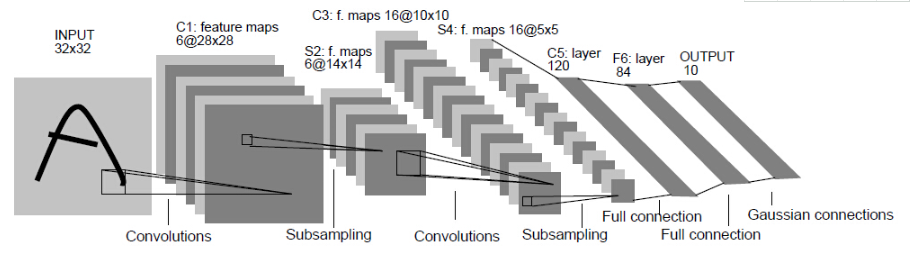

In [1]:
import d2lzh as d2l
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, nn
import time

net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        # Dense会默认将(批量大小, 通道, 高, 宽)形状的输入转换成
        # (批量大小, 通道 * 高 * 宽)形状的输入
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))

接下来我们构造一个高和宽均为28的单通道数据样本，并逐层进行前向计算来查看每个层的输出形状。

In [2]:
X = nd.random.uniform(shape=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1, 6, 24, 24)
pool0 output shape:	 (1, 6, 12, 12)
conv1 output shape:	 (1, 16, 8, 8)
pool1 output shape:	 (1, 16, 4, 4)
dense0 output shape:	 (1, 120)
dense1 output shape:	 (1, 84)
dense2 output shape:	 (1, 10)


可以看到，在卷积层块中输入的高和宽在逐层减小。卷积层由于使用高和宽均为5的卷积核，从而将高和宽分别减小4，而池化层则将高和宽减半，但通道数则从1增加到16。全连接层则逐层减少输出个数，直到变成图像的类别数10。


## 获取数据和训练模型

下面我们来实验LeNet模型。实验中，我们仍然使用Fashion-MNIST作为训练数据集。

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

因为卷积神经网络计算比多层感知机要复杂，建议使用GPU来加速计算。我们尝试在`gpu(0)`上创建`NDArray`，如果成功则使用`gpu(0)`，否则仍然使用CPU。

In [4]:
def try_gpu():  # 本函数已保存在d2lzh包中方便以后使用
    try:
        ctx = mx.gpu()
        _ = nd.zeros((1,), ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx

ctx = try_gpu()
ctx

cpu(0)

相应地，我们对[“softmax回归的从零开始实现”](../chapter_3_deep-learning-basics/softmax-regression-scratch.ipynb)一节中描述的`evaluate_accuracy`函数略作修改。由于数据刚开始存在CPU使用的内存上，当`ctx`变量代表GPU及相应的显存时，我们通过[“GPU计算”](../chapter_4_deep-learning-computation/use-gpu.ipynb)一节中介绍的`as_in_context`函数将数据复制到显存上，例如`gpu(0)`。

In [5]:
# 本函数已保存在d2lzh包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中
# 描述
def evaluate_accuracy(data_iter, net, ctx):
    acc_sum, n = nd.array([0], ctx=ctx), 0
    for X, y in data_iter:
        # 如果ctx代表GPU及相应的显存，将数据复制到显存上
        X, y = X.as_in_context(ctx), y.as_in_context(ctx).astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.size
    return acc_sum.asscalar() / n

我们同样对[“softmax回归的从零开始实现”](../chapter_3_deep-learning-basics/softmax-regression-scratch.ipynb)一节中定义的`train_ch3`函数略作修改，确保计算使用的数据和模型同在内存或显存上。

In [6]:
# 本函数已保存在d2lzh包中方便以后使用
def train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx,
              num_epochs):
    print('training on', ctx)
    loss = gloss.SoftmaxCrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

我们重新将模型参数初始化到设备变量`ctx`之上，并使用Xavier随机初始化。损失函数和训练算法则依然使用交叉熵损失函数和小批量随机梯度下降。

In [8]:
lr, num_epochs = 0.9, 5
net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

training on cpu(0)
epoch 1, loss 2.3194, train acc 0.101, test acc 0.100, time 24.2 sec
epoch 2, loss 1.9063, train acc 0.262, test acc 0.552, time 24.0 sec
epoch 3, loss 0.9512, train acc 0.624, test acc 0.696, time 24.2 sec
epoch 4, loss 0.7512, train acc 0.707, test acc 0.738, time 23.5 sec
epoch 5, loss 0.6641, train acc 0.737, test acc 0.750, time 23.7 sec


## 小结

* 卷积神经网络就是含卷积层的网络。
* LeNet交替使用卷积层和最大池化层后接全连接层来进行图像分类。


## 参考文献

[1] LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.

# 深度卷积神经网络（AlexNet）

在LeNet提出后的将近20年里，神经网络一度被其他机器学习方法超越，如支持向量机。虽然LeNet可以在早期的小数据集上取得好的成绩，但是在更大的真实数据集上的表现并不尽如人意。一方面，神经网络计算复杂。虽然20世纪90年代也有过一些针对神经网络的加速硬件，但并没有像之后GPU那样大量普及。因此，训练一个多通道、多层和有大量参数的卷积神经网络在当年很难完成。另一方面，当年研究者还没有大量深入研究参数初始化和非凸优化算法等诸多领域，导致复杂的神经网络的训练通常较困难。

我们在上一节看到，<font color='red'>神经网络可以直接基于图像的原始像素进行分类。这种称为端到端（end-to-end）的方法</font>节省了很多中间步骤。然而，在很长一段时间里更流行的是研究者通过勤劳与智慧所设计并生成的手工特征。这类图像分类研究的主要流程是：

1. 获取图像数据集；
2. 使用已有的特征提取函数生成图像的特征；
3. 使用机器学习模型对图像的特征分类。

当时认为的机器学习部分仅限最后这一步。如果那时候<font color='red'>跟机器学习研究者交谈</font>，他们会认为机器学习既重要又优美。优雅的定理证明了许多分类器的性质。机器学习领域生机勃勃、严谨而且极其有用。然而，如果跟<font color='red'>计算机视觉研究者交谈</font>，则是另外一幅景象。他们会告诉你图像识别里“不可告人”的现实是：计算机视觉流程中真正重要的是数据和特征。也就是说，使用较干净的数据集和较有效的特征甚至比机器学习模型的选择对图像分类结果的影响更大。


## 学习特征表示

既然特征如此重要，它该如何表示呢？

我们已经提到，在相当长的时间里，特征都是基于各式各样手工设计的函数从数据中提取的。事实上，不少研究者通过提出新的特征提取函数不断改进图像分类结果。这一度为计算机视觉的发展做出了重要贡献。

然而，另一些研究者则持异议。他们认为特征本身也应该由学习得来。他们还相信，为了表征足够复杂的输入，特征本身应该分级表示。持这一想法的研究者相信，多层神经网络可能可以学得数据的多级表征，并逐级表示越来越抽象的概念或模式。以图像分类为例，并回忆[“二维卷积层”](1-conv-layer.ipynb)一节中物体边缘检测的例子。<font color='red'>在多层神经网络中，图像的第一级的表示可以是在特定的位置和⻆度是否出现边缘；而第二级的表示说不定能够将这些边缘组合出有趣的模式，如花纹；在第三级的表示中，也许上一级的花纹能进一步汇合成对应物体特定部位的模式。这样逐级表示下去，最终，模型能够较容易根据最后一级的表示完成分类任务。</font>需要强调的是，输入的逐级表示由多层模型中的参数决定，而这些参数都是学出来的。

尽管一直有一群执着的研究者不断钻研，试图学习视觉数据的逐级表征，然而很长一段时间里这些野心都未能实现。这其中有诸多因素值得我们一一分析。


### 缺失要素一：数据

包含许多特征的深度模型需要大量的有标签的数据才能表现得比其他经典方法更好。限于早期计算机有限的存储和90年代有限的研究预算，大部分研究只基于小的公开数据集。例如，不少研究论文基于加州大学欧文分校（UCI）提供的若干个公开数据集，其中许多数据集只有几百至几千张图像。这一状况在2010年前后兴起的大数据浪潮中得到改善。特别是，2009年诞生的ImageNet数据集包含了1,000大类物体，每类有多达数千张不同的图像。这一规模是当时其他公开数据集无法与之相提并论的。ImageNet数据集同时推动计算机视觉和机器学习研究进入新的阶段，使此前的传统方法不再有优势。


### 缺失要素二：硬件

深度学习对计算资源要求很高。早期的硬件计算能力有限，这使训练较复杂的神经网络变得很困难。然而，通用GPU的到来改变了这一格局。很久以来，GPU都是为图像处理和计算机游戏设计的，尤其是针对大吞吐量的矩阵和向量乘法从而服务于基本的图形变换。值得庆幸的是，这其中的数学表达与深度网络中的卷积层的表达类似。通用GPU这个概念在2001年开始兴起，涌现出诸如OpenCL和CUDA之类的编程框架。这使得GPU也在2010年前后开始被机器学习社区使用。


## AlexNet

2012年，<font color='red'>AlexNet横空出世</font>。这个模型的名字来源于论文第一作者的姓名Alex Krizhevsky [1]。AlexNet使用了8层卷积神经网络，并以很大的优势赢得了ImageNet 2012图像识别挑战赛。它首次证明了学习到的特征可以超越手工设计的特征，从而一举打破计算机视觉研究的前状。

AlexNet与LeNet的设计理念非常相似，但也有显著的区别。

第一，与相对较小的LeNet相比，AlexNet包含8层变换，其中有5层卷积和2层全连接隐藏层，以及1个全连接输出层。下面我们来详细描述这些层的设计。

AlexNet第一层中的卷积窗口形状是$11\times11$。因为ImageNet中绝大多数图像的高和宽均比MNIST图像的高和宽大10倍以上，ImageNet图像的物体占用更多的像素，所以需要更大的卷积窗口来捕获物体。第二层中的卷积窗口形状减小到$5\times5$，之后全采用$3\times3$。此外，第一、第二和第五个卷积层之后都使用了窗口形状为$3\times3$、步幅为2的最大池化层。而且，AlexNet使用的卷积通道数也大于LeNet中的卷积通道数数十倍。

紧接着最后一个卷积层的是两个输出个数为4096的全连接层。这两个巨大的全连接层带来将近1 GB的模型参数。由于早期显存的限制，最早的AlexNet使用双数据流的设计使一个GPU只需要处理一半模型。幸运的是，显存在过去几年得到了长足的发展，因此通常我们不再需要这样的特别设计了。

第二，AlexNet将sigmoid激活函数改成了更加简单的ReLU激活函数。一方面，ReLU激活函数的计算更简单，例如它并没有sigmoid激活函数中的求幂运算。另一方面，ReLU激活函数在不同的参数初始化方法下使模型更容易训练。这是由于当sigmoid激活函数输出极接近0或1时，这些区域的梯度几乎为0，从而造成反向传播无法继续更新部分模型参数；而ReLU激活函数在正区间的梯度恒为1。因此，若模型参数初始化不当，sigmoid函数可能在正区间得到几乎为0的梯度，从而令模型无法得到有效训练。

第三，AlexNet通过丢弃法（参见[“丢弃法”](../chapter_3_deep-learning-basics/dropout.ipynb)一节）来控制全连接层的模型复杂度。而LeNet并没有使用丢弃法。

第四，AlexNet引入了大量的图像增广，如翻转、裁剪和颜色变化，从而进一步扩大数据集来缓解过拟合。我们将在后面的[“图像增广”](../chapter_computer-vision/image-augmentation.ipynb)一节详细介绍这种方法。

下面我们实现稍微简化过的AlexNet。
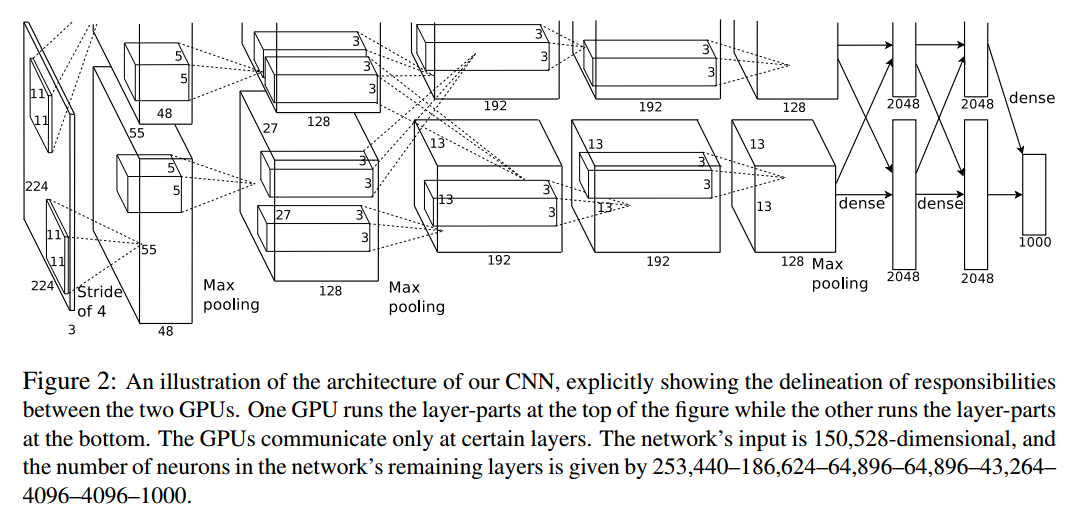

In [1]:
import d2lzh as d2l
from mxnet import gluon, init, nd
from mxnet.gluon import data as gdata, nn
import os
import sys

net = nn.Sequential()
# 使用较大的11 x 11窗口来捕获物体。同时使用步幅4来较大幅度减小输出高和宽。这里使用的输出通
# 道数比LeNet中的也要大很多
net.add(nn.Conv2D(96, kernel_size=11, strides=4, activation='relu'),
        nn.MaxPool2D(pool_size=3, strides=2),
        # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
        nn.Conv2D(256, kernel_size=5, padding=2, activation='relu'),
        nn.MaxPool2D(pool_size=3, strides=2),
        # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
        # 前两个卷积层后不使用池化层来减小输入的高和宽
        nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
        nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
        nn.Conv2D(256, kernel_size=3, padding=1, activation='relu'),
        nn.MaxPool2D(pool_size=3, strides=2),
        # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        nn.Dense(4096, activation="relu"), nn.Dropout(0.5),
        nn.Dense(4096, activation="relu"), nn.Dropout(0.5),
        # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
        nn.Dense(10))

我们构造一个高和宽均为224的单通道数据样本来观察每一层的输出形状。

In [2]:
X = nd.random.uniform(shape=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1, 96, 54, 54)
pool0 output shape:	 (1, 96, 26, 26)
conv1 output shape:	 (1, 256, 26, 26)
pool1 output shape:	 (1, 256, 12, 12)
conv2 output shape:	 (1, 384, 12, 12)
conv3 output shape:	 (1, 384, 12, 12)
conv4 output shape:	 (1, 256, 12, 12)
pool2 output shape:	 (1, 256, 5, 5)
dense0 output shape:	 (1, 4096)
dropout0 output shape:	 (1, 4096)
dense1 output shape:	 (1, 4096)
dropout1 output shape:	 (1, 4096)
dense2 output shape:	 (1, 10)


## 读取数据

虽然论文中AlexNet使用ImageNet数据集，但因为ImageNet数据集训练时间较长，我们仍用前面的Fashion-MNIST数据集来演示AlexNet。读取数据的时候我们额外做了一步将图像高和宽扩大到AlexNet使用的图像高和宽224。这个可以通过`Resize`实例来实现。也就是说，我们在`ToTensor`实例前使用`Resize`实例，然后使用`Compose`实例来将这两个变换串联以方便调用。

In [4]:
# 本函数已保存在d2lzh包中方便以后使用
def load_data_fashion_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.mxnet', 'datasets', 'fashion-mnist')):
    root = os.path.expanduser(root)  # 展开用户路径'~'
    transformer = []
    if resize:
        transformer += [gdata.vision.transforms.Resize(resize)]
    transformer += [gdata.vision.transforms.ToTensor()]
    transformer = gdata.vision.transforms.Compose(transformer)
    mnist_train = gdata.vision.FashionMNIST(root=root, train=True)
    mnist_test = gdata.vision.FashionMNIST(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4
    train_iter = gdata.DataLoader(
        mnist_train.transform_first(transformer), batch_size, shuffle=True,
        num_workers=num_workers)
    test_iter = gdata.DataLoader(
        mnist_test.transform_first(transformer), batch_size, shuffle=False,
        num_workers=num_workers)
    return train_iter, test_iter

batch_size = 128
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)

## 训练

这时候我们可以开始训练AlexNet了。相对于上一节的LeNet，这里的主要改动是使用了更小的学习率。

In [ ]:
lr, num_epochs, ctx = 0.01, 5, d2l.try_gpu()
net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
d2l.train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

## 小结

* AlexNet跟LeNet结构类似，但使用了更多的卷积层和更大的参数空间来拟合大规模数据集ImageNet。它是浅层神经网络和深度神经网络的分界线。
* 虽然看上去AlexNet的实现比LeNet的实现也就多了几行代码而已，但这个观念上的转变和真正优秀实验结果的产生令学术界付出了很多年。



## 参考文献

[1] Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. In Advances in neural information processing systems (pp. 1097-1105).